In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [114]:
df = pd.read_csv("../data/heart_data.csv")

df_dropped_rows = df.dropna()

df_dropped_columns = df.dropna(axis=1)

df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [115]:
df.sample(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
185,58,M,NAP,160,211,1,ST,92,N,0.0,Flat,1
275,59,M,NAP,180,213,0,Normal,100,N,0.0,Up,0
224,55,M,ATA,120,256,1,Normal,137,N,0.0,Up,0
460,57,M,ASY,139,277,1,ST,118,Y,1.9,Flat,1
701,62,M,ATA,128,208,1,LVH,140,N,0.0,Up,0


In [116]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()

df['ST_Slope'] = label_encoder.fit_transform(df['ST_Slope'])
df['ChestPainType'] = df['ChestPainType'].replace({'TA': 0, 'ATA': 1, 'NAP': 2, 'ASY': 3})
df['RestingECG'] = df['RestingECG'].replace({ "Normal": 0, "ST": 1, "LVH": 2})
df['ExerciseAngina'] = df['ExerciseAngina'].replace({"Y": 1, "N": 0})
df['Sex'] = df['Sex'].replace({ "M": 1, "F": 0 })


C:\Users\tokri\AppData\Local\Temp\ipykernel_5172\3958768428.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ChestPainType'] = df['ChestPainType'].replace({'TA': 0, 'ATA': 1, 'NAP': 2, 'ASY': 3})
C:\Users\tokri\AppData\Local\Temp\ipykernel_5172\3958768428.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RestingECG'] = df['RestingECG'].replace({ "Normal": 0, "ST": 1, "LVH": 2})
C:\Users\tokri\AppData\Local\Temp\ipykernel_5172\3958768428.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be r

In [117]:
df.columns

X = df.drop('HeartDisease', axis=1)

y = df['HeartDisease']

X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,1,1,140,289,0,0,172,0,0.0,2
1,49,0,2,160,180,0,0,156,0,1.0,1
2,37,1,1,130,283,0,1,98,0,0.0,2
3,48,0,3,138,214,0,0,108,1,1.5,1
4,54,1,2,150,195,0,0,122,0,0.0,2


In [118]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, y_train.shape

((642, 11), (642,))

In [119]:
from sklearn.ensemble import RandomForestClassifier

tree = RandomForestClassifier()

tree.fit(X_train, y_train)

RandomForestClassifier()

In [120]:
tree_pred = tree.predict(X_test)



In [125]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

matrix = confusion_matrix(y_test, tree_pred)

print(matrix)

[[100  12]
 [ 22 142]]


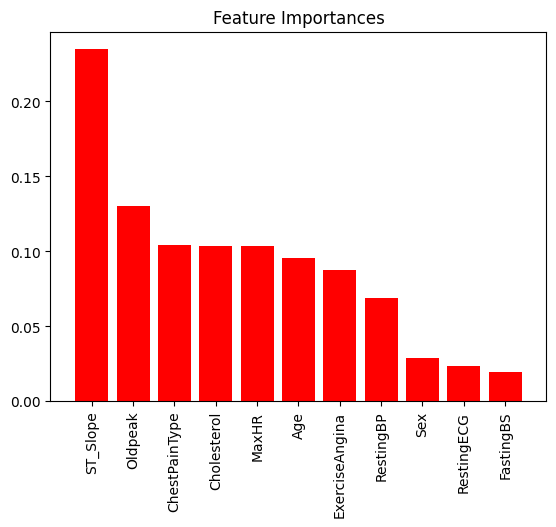

In [126]:
# Feature Importance
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

feature_names = list(df.columns)


plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [127]:
accuracy = accuracy_score(y_test, tree_pred)

print(f'Accuracy: {accuracy}')


cr = classification_report(y_test, tree_pred)

print(cr)

Accuracy: 0.8768115942028986
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       112
           1       0.92      0.87      0.89       164

    accuracy                           0.88       276
   macro avg       0.87      0.88      0.87       276
weighted avg       0.88      0.88      0.88       276



In [128]:
param_grid = {
    "n_estimators": range(50, 300, 50),         # Number of trees in the forest
    "max_depth": range(3, 11),                    # Maximum depth of each tree
    "min_samples_split": [2, 5, 10],              # Minimum number of samples required to split an internal node
    "min_samples_leaf": [1, 2, 4],                # Minimum number of samples required at a leaf node
    "max_features": ["sqrt", "log2", None],       # Number of features to consider when looking for the best split
    "bootstrap": [True, False]                    # Whether bootstrap samples are used when building trees
}


tree_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

tree_grid.fit(X_train, y_train)


best_params = tree_grid.best_params_

print(f'Best Hyperparamers: {best_params}')

tree_pred = tree_grid.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, tree_pred)
print(f'Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_test, tree_pred)
print('Confusion Matrix:')
print(cm)

cr = classification_report(y_test, tree_pred)
print('Classification Report:')
print(cr)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


KeyboardInterrupt: 

In [129]:
import joblib

joblib.dump(tree, "model.pkl")

['model.pkl']